## VEHICLE CLASSIFICATION USING DIFFERENT OPTIMIZATION ALGORITHMS

**Presented by Sawan Aich**<br>
**BIG DATA ANALYTICS**<br>
**RKMVERI, BELUR**

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
import os,os.path

train_path="/content/drive/MyDrive/vehicle_classification/vechicles/train"
test_path="/content/drive/MyDrive/vehicle_classification/vechicles/test"
classes=["bike","boat","bus","car","cycle","helicopter","plane","scooty","truck"]

Text(0.5, 1.0, 'Training Dataset')

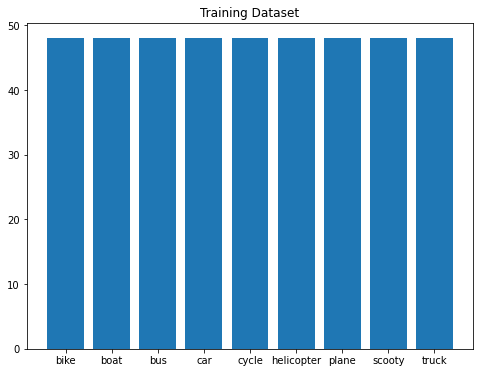

In [ ]:
file_size=[]
for i in classes:
  file_size.append(len([item for item in os.listdir(train_path+"/"+i)]))

import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(8, 6))
plt.bar(classes,file_size)
plt.title("Training Dataset")

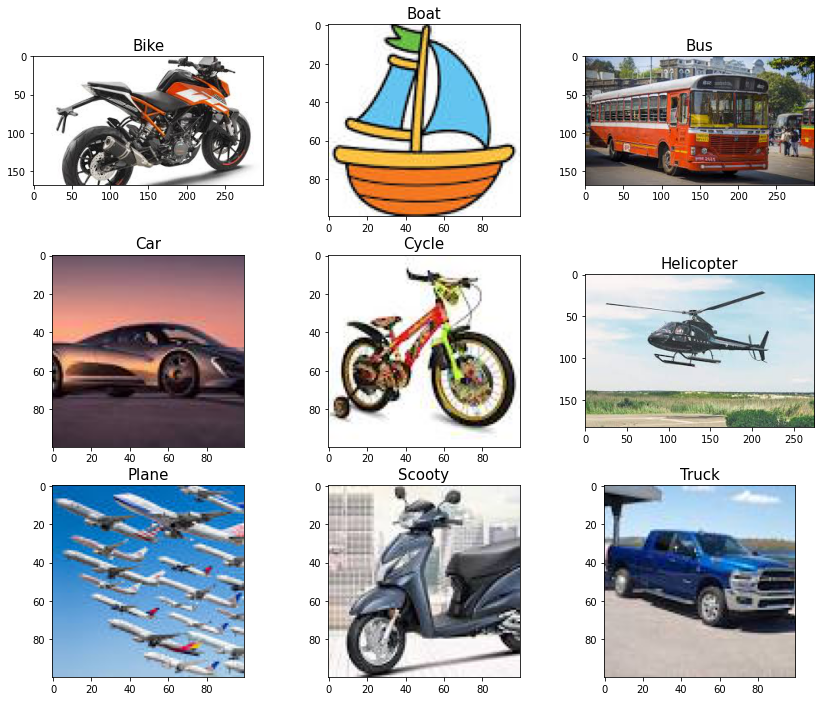

In [ ]:
plt.figure(figsize=(14,12))
for i in range(9):
  plt.subplot(3,3,i+1)
  im=os.listdir(train_path + "/" + classes[i] + "/")[0]
  im2=plt.imread(train_path + "/" + classes[i] + "/" + im)
  plt.imshow(im2)
  plt.title(str(classes[i]).capitalize(),size=15)

In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 30
# percentage of training set to use as validation
valid_size = 0.3

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((256,256)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data = datasets.ImageFolder(train_path, transform=transform)
test_data = datasets.ImageFolder(test_path, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

#### A glimpse of the dataset is shown below

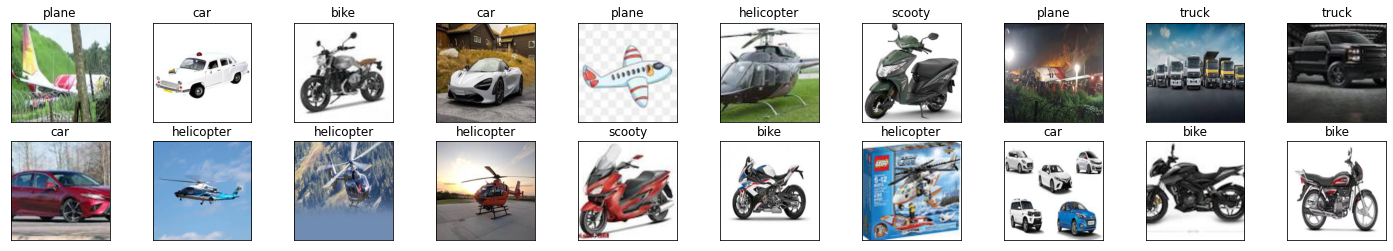

In [ ]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### The CNN Model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 32 * 32, 500)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, 9)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        # flatten image input
        x = x.view(-1, 64 * 32 * 32)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=65536, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=9, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [ ]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

32796817

In [ ]:
import torch.optim as optim
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer_sgd = optim.SGD(model.parameters(), lr=0.0001, weight_decay=1e-5)
optimizer_sgd_mom = optim.SGD(model.parameters(), lr=0.001, momentum = 0.5, weight_decay=1e-5)
optimizer_rmsprop = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=1e-5)
optimizer_adam = optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-5)

### OPTIMIZATION ALGORITHMS

### i) SGD <br>

Originally we are using Mini-Batch gradient descent here. Mini-Batch gradient decent integrates the advantages of batch gradient decent and stochastic gradient decent, and update the parameters after obtaining the gradient of a mini-batch of samples:
$$x_{k+1} = x_{k} − t_{k}\nabla f(x_{k})^{(i:i+m)}$$
where the mini-batch size is m.<br>
Mini-batch gradient decent can not guarantee good convergence, and the tuning of step size also need some experience. Therefore some researchers extend it with some more useful tricks and techniques to improve the convergence which we will see. For convenience, people also call mini-batch gradient decent as SGD.

In [ ]:
# number of epochs to train the model
n_epochs = 15

valid_loss_min = np.Inf # track change in validation loss

train_loss_list = []
valid_loss_list = []

conv1_grad=[]
conv2_grad=[]
conv3_grad=[]

conv1_bias=[]
conv2_bias=[]
conv3_bias=[]

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer_sgd.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # perform a single optimization step (parameter update)
        optimizer_sgd.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    conv1_grad.append(torch.linalg.norm(model.conv1.weight.grad))
    conv2_grad.append(torch.linalg.norm(model.conv2.weight.grad))
    conv3_grad.append(torch.linalg.norm(model.conv3.weight.grad))
    conv1_bias.append(torch.linalg.norm(model.conv1.bias.grad))
    conv2_bias.append(torch.linalg.norm(model.conv2.bias.grad))
    conv3_bias.append(torch.linalg.norm(model.conv3.bias.grad))
    # print("conv1 grads",torch.linalg.norm(model.conv1.weight.grad)) 
    # print("conv2 grads",torch.linalg.norm(model.conv2.bias.grad))
    # print("conv2 grads",torch.linalg.norm(model.conv2.bias.grad))
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1 	Training Loss: 2.239496 	Validation Loss: 2.204722
Validation loss decreased (inf --> 2.204722).  Saving model ...
Epoch: 2 	Training Loss: 2.200487 	Validation Loss: 2.199925
Validation loss decreased (2.204722 --> 2.199925).  Saving model ...
Epoch: 3 	Training Loss: 2.187760 	Validation Loss: 2.186140
Validation loss decreased (2.199925 --> 2.186140).  Saving model ...
Epoch: 4 	Training Loss: 2.148000 	Validation Loss: 2.169957
Validation loss decreased (2.186140 --> 2.169957).  Saving model ...
Epoch: 5 	Training Loss: 2.115502 	Validation Loss: 2.125875
Validation loss decreased (2.169957 --> 2.125875).  Saving model ...
Epoch: 6 	Training Loss: 2.098614 	Validation Loss: 2.108948
Validation loss decreased (2.125875 --> 2.108948).  Saving model ...
Epoch: 7 	Training Loss: 2.064144 	Validation Loss: 2.088629
Validation loss decreased (2.108948 --> 2.088629).  Saving model ...
Epoch: 8 	Training Loss: 2.046908 	Validation Loss: 2.083919
Validation loss decreased (2.08862

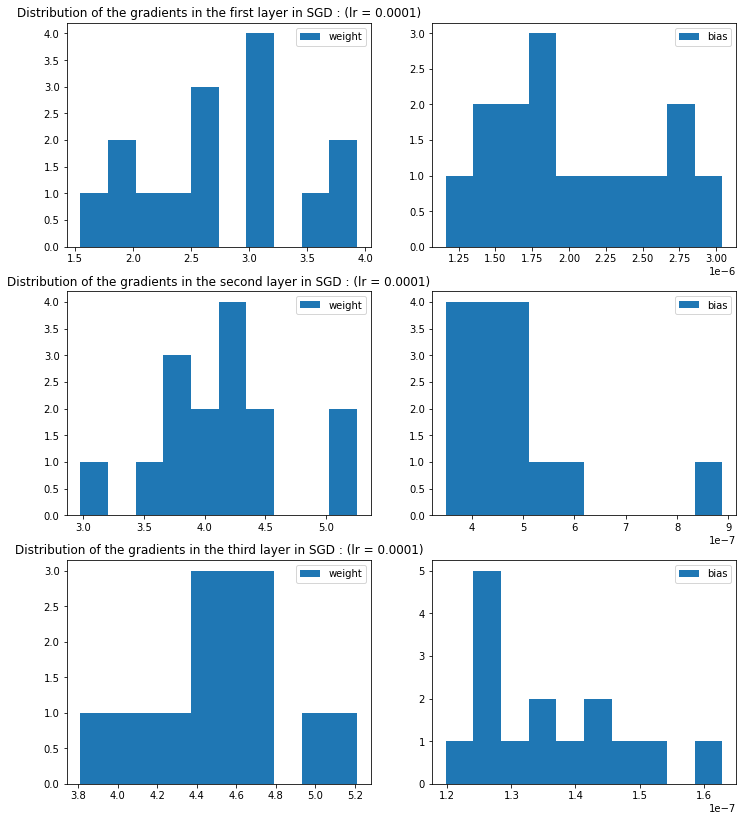

In [ ]:
import pandas as pd
import seaborn as sns
fig,axes=plt.subplots(figsize=(12,14))
plt.subplot(321)
plt.hist([i.item() for i in conv1_grad])
plt.legend(['weight'])
plt.title("Distribution of the gradients in the first layer in SGD : (lr = 0.0001)")
plt.subplot(322)
plt.hist([i.item() for i in conv1_bias])
plt.legend(['bias'])

plt.subplot(323)
plt.hist([i.item() for i in conv2_grad])
plt.legend(['weight'])
plt.title("Distribution of the gradients in the second layer in SGD : (lr = 0.0001)")
plt.subplot(324)
plt.hist([i.item() for i in conv2_bias])
plt.legend(['bias'])

plt.subplot(325)
plt.hist([i.item() for i in conv3_grad])
plt.legend(['weight'])
plt.title("Distribution of the gradients in the third layer in SGD : (lr = 0.0001)")
plt.subplot(326)
plt.hist([i.item() for i in conv3_bias])
plt.legend(['bias'])

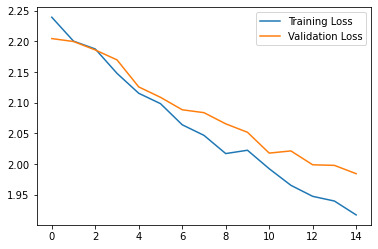

In [ ]:
plt.plot(train_loss_list,label="Training Loss")
plt.plot(valid_loss_list,label="Validation Loss")
plt.legend()

### ii) SGD with momentum

If there is a long shallow ravine with steep walls on the direction to the optimal point, then the standard SGD will tend to oscillate across the narrow ravine. Momentum is one of the mechanism which is used to fix the direction:
$$v_{k} = mv_{k−1} + t_{k}\nabla f(x_{k}) ;\;\;\; x_{k+1} = x_{k} − v_{k}$$

where m ∈ (0, 1] determines for how many iterations the previous gradients are incorporated into the current update. Generally m is set to 0.5 until the initial learning stabilizes and then is increased to 0.9 or higher.

In [ ]:
# number of epochs to train the model
n_epochs = 15

valid_loss_min = np.Inf # track change in validation loss

train_loss_list2 = []
valid_loss_list2 = []

conv1_grad2=[]
conv2_grad2=[]
conv3_grad2=[]

conv1_bias2=[]
conv2_bias2=[]
conv3_bias2=[]

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer_sgd_mom.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # perform a single optimization step (parameter update)
        optimizer_sgd_mom.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    conv1_grad2.append(torch.linalg.norm(model.conv1.weight.grad))
    conv2_grad2.append(torch.linalg.norm(model.conv2.weight.grad))
    conv3_grad2.append(torch.linalg.norm(model.conv3.weight.grad))
    conv1_bias2.append(torch.linalg.norm(model.conv1.bias.grad))
    conv2_bias2.append(torch.linalg.norm(model.conv2.bias.grad))
    conv3_bias2.append(torch.linalg.norm(model.conv3.bias.grad))
    # print("conv1 grads",torch.linalg.norm(model.conv1.weight.grad)) 
    # print("conv2 grads",torch.linalg.norm(model.conv2.bias.grad))
    # print("conv2 grads",torch.linalg.norm(model.conv2.bias.grad))
    train_loss_list2.append(train_loss)
    valid_loss_list2.append(valid_loss)
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 2.147188 	Validation Loss: 2.178032
Validation loss decreased (inf --> 2.178032).  Saving model ...
Epoch: 2 	Training Loss: 1.907428 	Validation Loss: 2.145702
Validation loss decreased (2.178032 --> 2.145702).  Saving model ...
Epoch: 3 	Training Loss: 1.648316 	Validation Loss: 2.009681
Validation loss decreased (2.145702 --> 2.009681).  Saving model ...
Epoch: 4 	Training Loss: 1.493434 	Validation Loss: 2.111584
Epoch: 5 	Training Loss: 1.450556 	Validation Loss: 2.001716
Validation loss decreased (2.009681 --> 2.001716).  Saving model ...
Epoch: 6 	Training Loss: 1.307338 	Validation Loss: 1.933382
Validation loss decreased (2.001716 --> 1.933382).  Saving model ...
Epoch: 7 	Training Loss: 1.136390 	Validation Loss: 1.786877
Validation loss decreased (1.933382 --> 1.786877).  Saving model ...
Epoch: 8 	Training Loss: 1.023173 	Validation Loss: 1.782284
Validation loss decreased (1.786877 --> 1.782284).  Saving model ...
Epoch: 9 	Training Loss: 0.951022 

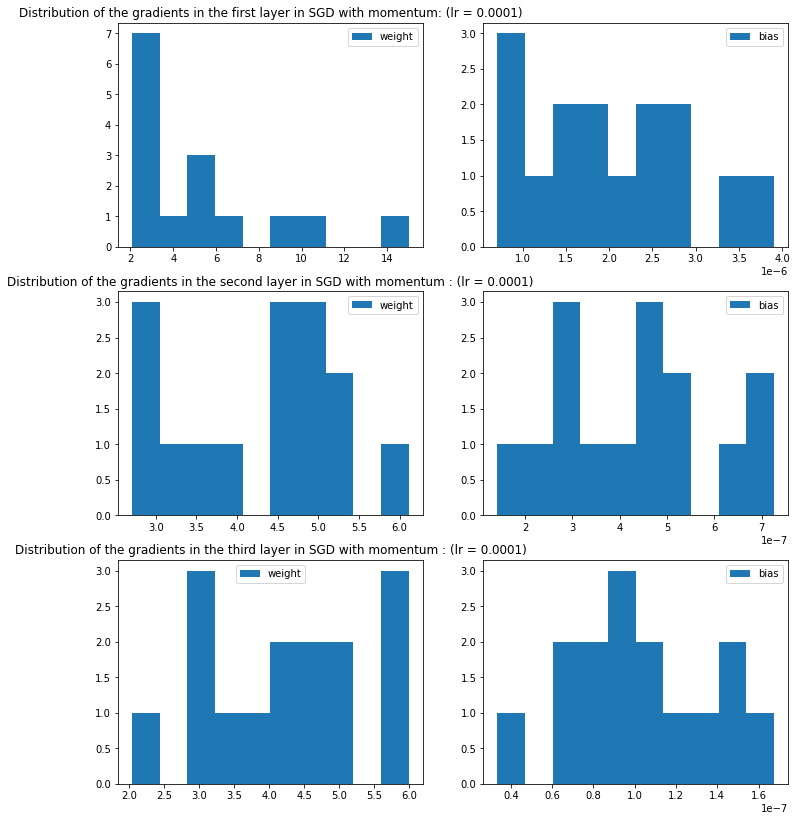

In [ ]:
fig,axes=plt.subplots(figsize=(12,14))
plt.subplot(321)
plt.hist([i.item() for i in conv1_grad2])
plt.legend(['weight'])
plt.title("Distribution of the gradients in the first layer in SGD with momentum: (lr = 0.0001)")
plt.subplot(322)
plt.hist([i.item() for i in conv1_bias2])
plt.legend(['bias'])

plt.subplot(323)
plt.hist([i.item() for i in conv2_grad2])
plt.legend(['weight'])
plt.title("Distribution of the gradients in the second layer in SGD with momentum : (lr = 0.0001)")
plt.subplot(324)
plt.hist([i.item() for i in conv2_bias2])
plt.legend(['bias'])

plt.subplot(325)
plt.hist([i.item() for i in conv3_grad2])
plt.legend(['weight'])
plt.title("Distribution of the gradients in the third layer in SGD with momentum : (lr = 0.0001)")
plt.subplot(326)
plt.hist([i.item() for i in conv3_bias2])
plt.legend(['bias'])

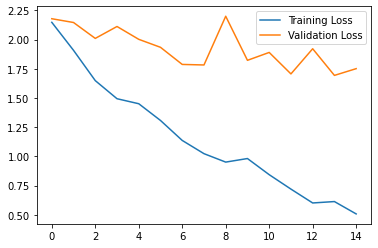

In [ ]:
plt.plot(train_loss_list2,label="Training Loss")
plt.plot(valid_loss_list2,label="Validation Loss")
plt.legend()

### iii) RMSprop <br>

RMSprop is proposed to tackle the problem of step size vanishing of Adagrad. It employs the decaying average of the history gradients:

$$E[\nabla f(x)^{2}]_{k} = ρE[\nabla f(x)^{2}]_{k−1} + (1 − ρ)\nabla f(x_{k})^{2} $$
$$x_{k+1} = x_{k} − \frac{t}{\sqrt{E[\nabla f(x)2]_{k} + ε}}\nabla f(x_{k})$$

where ρ is a decay constant (e.g., 0.9).

In [ ]:
# number of epochs to train the model
n_epochs = 20

valid_loss_min = np.Inf # track change in validation loss

train_loss_list3 = []
valid_loss_list3 = []

conv1_grad3=[]
conv2_grad3=[]
conv3_grad3=[]

conv1_bias3=[]
conv2_bias3=[]
conv3_bias3=[]

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer_rmsprop.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer_rmsprop.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    conv1_grad3.append(torch.linalg.norm(model.conv1.weight.grad))
    conv2_grad3.append(torch.linalg.norm(model.conv2.weight.grad))
    conv3_grad3.append(torch.linalg.norm(model.conv3.weight.grad))
    conv1_bias3.append(torch.linalg.norm(model.conv1.bias.grad))
    conv2_bias3.append(torch.linalg.norm(model.conv2.bias.grad))
    conv3_bias3.append(torch.linalg.norm(model.conv3.bias.grad))

    train_loss_list3.append(train_loss)
    valid_loss_list3.append(valid_loss)
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1 	Training Loss: 171.538199 	Validation Loss: 14.418951
Validation loss decreased (inf --> 14.418951).  Saving model ...
Epoch: 2 	Training Loss: 12.566399 	Validation Loss: 4.598886
Validation loss decreased (14.418951 --> 4.598886).  Saving model ...
Epoch: 3 	Training Loss: 3.434449 	Validation Loss: 2.192507
Validation loss decreased (4.598886 --> 2.192507).  Saving model ...
Epoch: 4 	Training Loss: 2.031450 	Validation Loss: 2.430664
Epoch: 5 	Training Loss: 1.974862 	Validation Loss: 2.307627
Epoch: 6 	Training Loss: 1.903619 	Validation Loss: 2.098570
Validation loss decreased (2.192507 --> 2.098570).  Saving model ...
Epoch: 7 	Training Loss: 1.829403 	Validation Loss: 2.258425
Epoch: 8 	Training Loss: 1.728815 	Validation Loss: 2.109190
Epoch: 9 	Training Loss: 1.714708 	Validation Loss: 2.169879
Epoch: 10 	Training Loss: 1.676709 	Validation Loss: 2.999394
Epoch: 11 	Training Loss: 1.633257 	Validation Loss: 2.174101
Epoch: 12 	Training Loss: 1.524554 	Validation Los

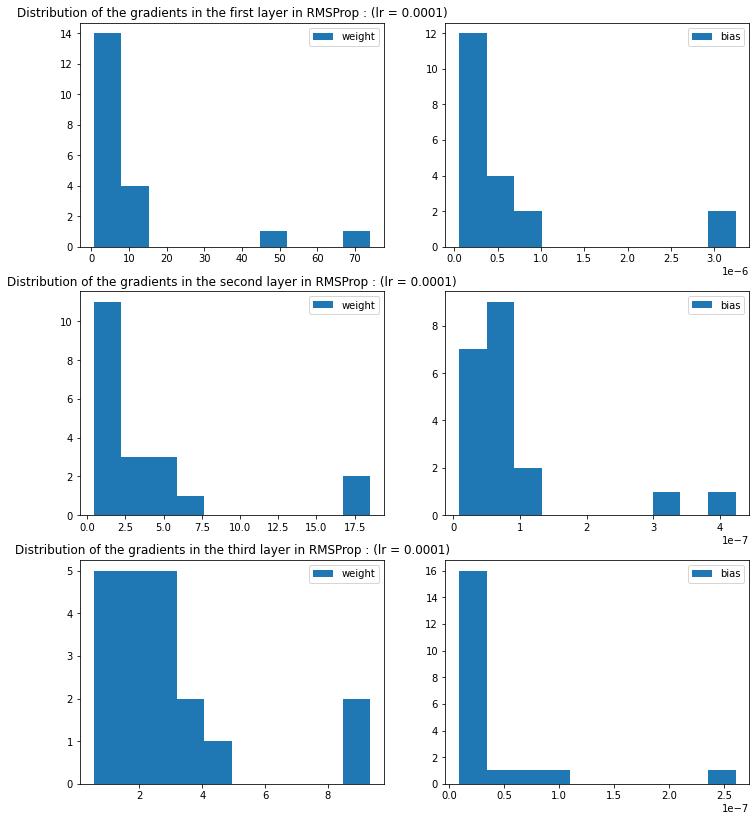

In [ ]:
fig,axes=plt.subplots(figsize=(12,14))
plt.subplot(321)
plt.hist([i.item() for i in conv1_grad3])
plt.legend(['weight'])
plt.title("Distribution of the gradients in the first layer in RMSProp : (lr = 0.0001)")
plt.subplot(322)
plt.hist([i.item() for i in conv1_bias3])
plt.legend(['bias'])

plt.subplot(323)
plt.hist([i.item() for i in conv2_grad3])
plt.legend(['weight'])
plt.title("Distribution of the gradients in the second layer in RMSProp : (lr = 0.0001)")
plt.subplot(324)
plt.hist([i.item() for i in conv2_bias3])
plt.legend(['bias'])

plt.subplot(325)
plt.hist([i.item() for i in conv3_grad3])
plt.legend(['weight'])
plt.title("Distribution of the gradients in the third layer in RMSProp : (lr = 0.0001)")
plt.subplot(326)
plt.hist([i.item() for i in conv3_bias3])
plt.legend(['bias'])

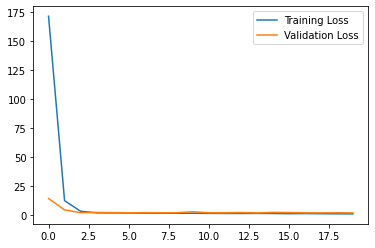

In [ ]:
plt.plot(train_loss_list3,label="Training Loss")
plt.plot(valid_loss_list3,label="Validation Loss")
plt.legend()

### iv) Adam <br>
Adam optimization algorithm is an extension to stochastic gradient descent. It was presented in 2015.The name **Adam** is derived from **Adaptive moment estimation**.The authors describe Adam as combining the advantages of two other extensions of stochastic gradient descent algorithm.

Adam is another method that computes adaptive step size for each parameter. It uses both the decaying average of history gradients and their squared values. Adam update rule consists of the
following steps:

$$m_{k} = β_{1}m_{k−1} + (1 − β_{1})\nabla f(x_{k})$$
$$v_{k} = β_{2}v_{k−1} + (1 − β_{2})\nabla f(x_{k})^{2}$$
$$mˆ_{k} = \frac{m_{k}}{1 − β_{k}^{1}} ;\;\; vˆ_{k} = \frac{v_{k}}{1 − β_{k}^{2}}$$
$$x_{k+1} = x_{k} − \frac{t}{\sqrt{vˆ_{k} + ε}}mˆ_{k}$$

where β1 can be 0.9, β2 can be 0.999, and ε can be 1e − 8.

Instead of adapting the parameter learning rates based on the average first moment (the mean) as in RMSProp, Adam also makes use of the average of the second moments of the gradients (the uncentered variance).

In [ ]:
# number of epochs to train the model
n_epochs = 15

valid_loss_min = np.Inf # track change in validation loss

train_loss_list4 = []
valid_loss_list4 = []

conv1_grad4=[]
conv2_grad4=[]
conv3_grad4=[]

conv1_bias4=[]
conv2_bias4=[]
conv3_bias4=[]

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer_adam.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer_adam.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    conv1_grad4.append(torch.linalg.norm(model.conv1.weight.grad))
    conv2_grad4.append(torch.linalg.norm(model.conv2.weight.grad))
    conv3_grad4.append(torch.linalg.norm(model.conv3.weight.grad))
    conv1_bias4.append(torch.linalg.norm(model.conv1.bias.grad))
    conv2_bias4.append(torch.linalg.norm(model.conv2.bias.grad))
    conv3_bias4.append(torch.linalg.norm(model.conv3.bias.grad))
    
    train_loss_list4.append(train_loss)
    valid_loss_list4.append(valid_loss)
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1 	Training Loss: 107.457921 	Validation Loss: 14.022081
Validation loss decreased (inf --> 14.022081).  Saving model ...
Epoch: 2 	Training Loss: 10.734664 	Validation Loss: 2.420703
Validation loss decreased (14.022081 --> 2.420703).  Saving model ...
Epoch: 3 	Training Loss: 2.325758 	Validation Loss: 2.197793
Validation loss decreased (2.420703 --> 2.197793).  Saving model ...
Epoch: 4 	Training Loss: 2.194051 	Validation Loss: 2.181939
Validation loss decreased (2.197793 --> 2.181939).  Saving model ...
Epoch: 5 	Training Loss: 2.147501 	Validation Loss: 2.188330
Epoch: 6 	Training Loss: 2.137756 	Validation Loss: 2.199126
Epoch: 7 	Training Loss: 2.092151 	Validation Loss: 2.239401
Epoch: 8 	Training Loss: 2.094167 	Validation Loss: 2.185222
Epoch: 9 	Training Loss: 2.028689 	Validation Loss: 2.137910
Validation loss decreased (2.181939 --> 2.137910).  Saving model ...
Epoch: 10 	Training Loss: 2.012765 	Validation Loss: 2.080675
Validation loss decreased (2.137910 --> 2.0

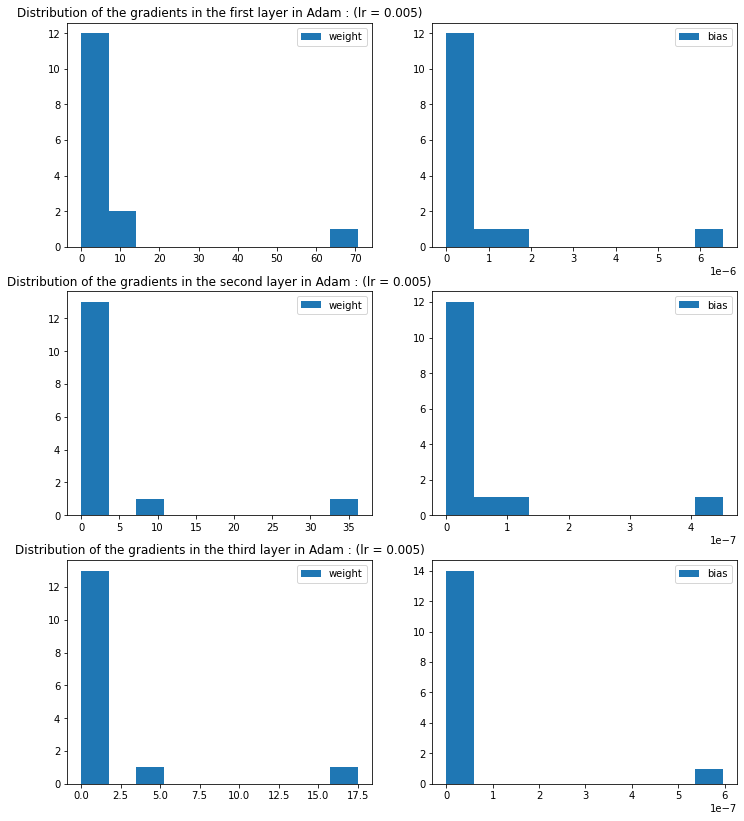

In [ ]:
fig,axes=plt.subplots(figsize=(12,14))
plt.subplot(321)
plt.hist([i.item() for i in conv1_grad4])
plt.legend(['weight'])
plt.title("Distribution of the gradients in the first layer in Adam : (lr = 0.005)")
plt.subplot(322)
plt.hist([i.item() for i in conv1_bias4])
plt.legend(['bias'])

plt.subplot(323)
plt.hist([i.item() for i in conv2_grad4])
plt.legend(['weight'])
plt.title("Distribution of the gradients in the second layer in Adam : (lr = 0.005)")
plt.subplot(324)
plt.hist([i.item() for i in conv2_bias4])
plt.legend(['bias'])

plt.subplot(325)
plt.hist([i.item() for i in conv3_grad4])
plt.legend(['weight'])
plt.title("Distribution of the gradients in the third layer in Adam : (lr = 0.005)")
plt.subplot(326)
plt.hist([i.item() for i in conv3_bias4])
plt.legend(['bias'])

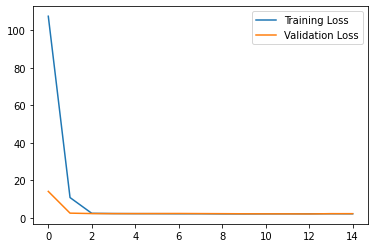

In [ ]:
plt.plot(train_loss_list4,label="Training Loss")
plt.plot(valid_loss_list4,label="Validation Loss")
plt.legend()

Text(0.5, 1.0, 'Adam')

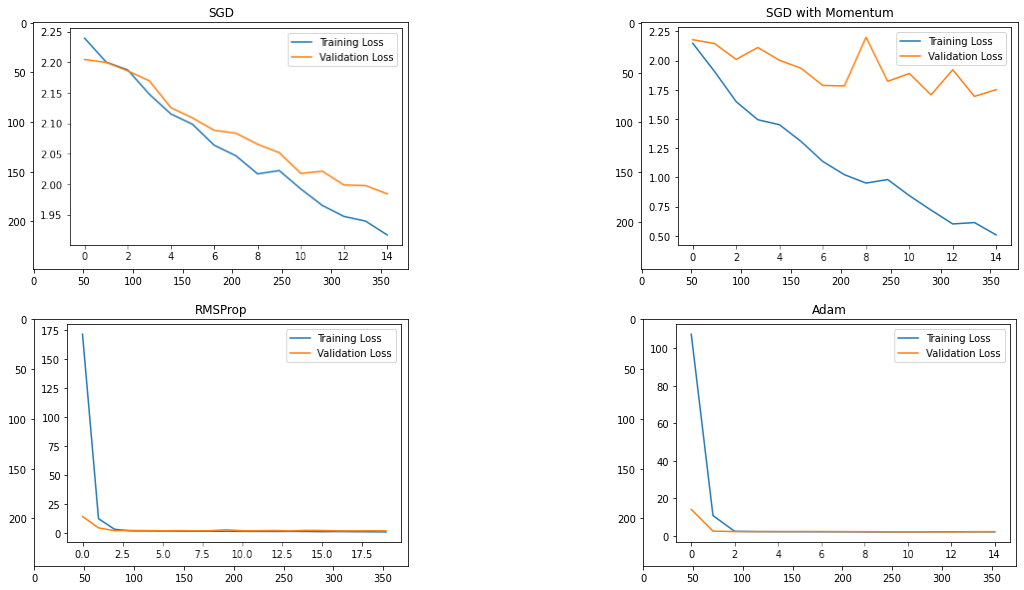

In [ ]:
from PIL import Image
import cv2
plt.figure(figsize=(20,10))

plt.subplot(221)
img_PIL = Image.open(r"/content/drive/MyDrive/vehicle_classification/vechicles/SGD.png")
plt.imshow(img_PIL)
plt.title('SGD')

plt.subplot(222)
img_PIL=Image.open(r"/content/drive/MyDrive/vehicle_classification/vechicles/SGD_Mom.png")
plt.imshow(img_PIL)
plt.title('SGD with Momentum')

plt.subplot(223)
img_PIL=Image.open(r"/content/drive/MyDrive/vehicle_classification/vechicles/RMSProp.png")
plt.imshow(img_PIL)
plt.title('RMSProp')

plt.subplot(224)
img_PIL=Image.open(r"/content/drive/MyDrive/vehicle_classification/vechicles/Adam.png")
plt.imshow(img_PIL)
plt.title('Adam')

## Checking the performance on test cases

In [ ]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(9))
class_total = list(0. for i in range(9))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(9):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(9):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 2.014983

Test Accuracy of  bike: 100% ( 9/ 9)
Test Accuracy of  boat:  0% ( 0/ 8)
Test Accuracy of   bus:  0% ( 0/ 1)
Test Accuracy of   car: 55% ( 5/ 9)
Test Accuracy of cycle:  0% ( 0/ 5)
Test Accuracy of helicopter:  0% ( 0/ 4)
Test Accuracy of plane: 11% ( 1/ 9)
Test Accuracy of scooty:  0% ( 0/ 2)
Test Accuracy of truck:  0% ( 0/ 7)

Test Accuracy (Overall): 27% (15/54)


To conclude, it can be said that as the dataset is pretty small, the test accuracy of the model is not very satisfying. However, ADAM optimizer as well as the RMSprop optimizer helps in some aggressive decrease in the training loss. It can be inferred to some extent that Adam and RMSprop can work a bit better that normal SGD or SGD with momentum for smaller datasets.